# Analítica y Ciencia de Datos

## CIDE - Otoño 2015


### Solución Tarea 6: Modelos de Clasificación.

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('/Users/danielvaughan/Documents/Python Scripts')
import olsdan as ols
import matplotlib.pyplot as plt
%matplotlib inline

## Punto 1: Vamos a limpiar los datos

In [286]:
data = pd.read_excel('/Users/danielvaughan/Documents/Clase CIDE/Slides/Analitica/datasets/data_tarea6.xlsx')

In [287]:
data.head()

,id_cliente,MOB,EDAD_CLIENTE,SEXO,UN_MESES_SINPAGO,FACT_PROM_6M_ANTES,PAYRATIO_PROM_6M_ANTES,BALANCE_PROM_6M_ANTES,USOVECES_PROM_6M_ANTES,TKTPROM_PROM_6M_ANTES,SCORE_LAST,SCORE_FIRST
0,1,32,43,M,0,0.000000,0.000000,0.000000,0.000000,0.000000,771,767
1,2,61,41,M,0,2353.033333,1.652819,2357.733333,3.633333,88.201330,616,611
2,3,35,37,M,0,21.542857,0.203771,6774.142857,0.028571,17.514286,561,587
3,4,27,35,F,1,1150.444444,3.484363,1506.703704,1.185185,229.744092,605,616
4,5,42,28,F,0,215.523810,1.291662,775.309524,0.142857,80.047619,752,758


In [288]:
# Eliminar aquellos con filas cero: son 12% de los clientes
ind_cero = data[[u'FACT_PROM_6M_ANTES',u'PAYRATIO_PROM_6M_ANTES', u'BALANCE_PROM_6M_ANTES',
                 u'USOVECES_PROM_6M_ANTES',  u'TKTPROM_PROM_6M_ANTES']].sum(axis=1)==0
print ind_cero.mean(), data.shape

data.drop(data[ind_cero].index, axis=0, inplace=True)
print data.shape

0.12 (500, 12)
(440, 12)


In [289]:
# Género a una dummy: 59% de la muestra son hombres
hombre_dum = 1.0*(data.SEXO=='M')
hombre_dum[data.SEXO.isnull()==True] =  np.nan
print hombre_dum.mean()

0.598465473146


In [290]:
# Variable dependiente: 20% de la muestra se ha atrasado por lo menos una vez
yy = 1.0*(data.UN_MESES_SINPAGO>0)
yy[data.UN_MESES_SINPAGO.isnull()] = np.nan
print yy.mean()
data.UN_MESES_SINPAGO.groupby(data.UN_MESES_SINPAGO).count()
nobs = yy.shape[0]
yy = yy.reshape((nobs,1))


0.206818181818


In [291]:
# Arreglemos los regresores que vamos a utilizar
antiguedad  = np.asarray(data.MOB).reshape((nobs,1))
edad_clie   = np.asarray(data.EDAD_CLIENTE).reshape((nobs,1))
edad2_clie  = edad_clie**2
factu_antes = np.asarray(data.FACT_PROM_6M_ANTES).reshape((nobs,1))
payratio    = np.asarray(data.PAYRATIO_PROM_6M_ANTES).reshape((nobs,1))
saldo_antes = np.asarray(data.BALANCE_PROM_6M_ANTES).reshape((nobs,1))
uso_antes   = np.asarray(data.USOVECES_PROM_6M_ANTES).reshape((nobs,1))
tktprom_ant = np.asarray(data.TKTPROM_PROM_6M_ANTES).reshape((nobs,1))
# SCORE: miremos que no haya negativos
data.SCORE_LAST.loc[data.SCORE_LAST<0] = np.nan
data.SCORE_FIRST.loc[data.SCORE_FIRST<0] = np.nan
score_last  = np.asarray(data.SCORE_LAST).reshape((nobs,1))
score_delta = np.asarray(data.SCORE_LAST - data.SCORE_FIRST).reshape((nobs,1))

In [297]:
xmat   = np.concatenate((antiguedad, edad_clie, factu_antes,
                      payratio, saldo_antes, uso_antes, tktprom_ant, score_last, score_delta),axis=1)
labs_x = np.array(['antiguedad', 'edad_clie', 'factu_antes','payratio', 'saldo_antes', 'uso_antes', 
          'tktprom_ant', 'score_last', 'score_delta'])

xmat_cons = np.concatenate((np.ones((nobs,1)),antiguedad, edad_clie, factu_antes,
                      payratio, saldo_antes, uso_antes, tktprom_ant, score_last, score_delta),axis=1)
labs_x_cons = np.array(['constante','antiguedad', 'edad_clie', 'factu_antes','payratio', 'saldo_antes', 'uso_antes', 
          'tktprom_ant', 'score_last', 'score_delta'])


In [82]:
# Vamos a eliminar los nans
# necesitamos concatenar Y y X, eliminar, y volver a separar
predata = np.asarray(pd.DataFrame(np.concatenate((yy,xmat),axis=1)).dropna())
nobs = predata.shape[0]
yy   = predata[:,0].reshape((nobs,1))
xmat = predata[:,1:]
print yy.shape, xmat.shape

(384, 1) (384, 9)


# Punto 2: Lasso y Modelo Lineal de Probabilidad

In [98]:
# Para no penalizar la constante: medias cero
yy_std = yy - np.mean(yy)
prexmat_std = xmat.copy()
nobs, nvar = prexmat_std.shape
prexmat_std -= prexmat_std.mean(axis=0).reshape((1,nvar))

In [84]:
pd.DataFrame(prexmat_std).describe()

,0,1,2,3,4,5,6,7,8
count,384.000000,3.840000e+02,3.840000e+02,3.840000e+02,3.840000e+02,3.840000e+02,3.840000e+02,3.840000e+02,384.000000
mean,0.000000,-6.772360e-15,-4.556355e-13,-1.821460e-15,-1.005418e-12,-1.393561e-16,6.054416e-14,-3.789561e-14,0.000000
std,38.269320,1.091924e+01,1.606062e+03,2.552374e+00,4.047146e+03,1.239815e+00,2.200555e+02,5.362701e+01,27.235766
min,-38.953125,-2.099740e+01,-8.172067e+02,-1.476013e+00,-1.204876e+04,-8.344817e-01,-1.538020e+02,-1.528724e+02,-110.140625
25%,-25.953125,-8.997396e+00,-7.020734e+02,-1.267160e+00,-1.909616e+03,-6.806357e-01,-1.212896e+02,-3.337240e+01,-7.140625
50%,-11.953125,-9.973958e-01,-4.706118e+02,-9.377056e-01,-1.167282e+03,-4.076962e-01,-7.164976e+01,8.127604e+00,1.859375
75%,10.296875,9.002604e+00,5.899390e+01,1.805201e-01,3.836276e+02,1.863518e-01,2.289922e+01,4.112760e+01,7.859375
max,227.046875,2.700260e+01,1.366311e+04,2.329729e+01,3.633554e+04,9.765518e+00,1.518531e+03,9.712760e+01,149.859375


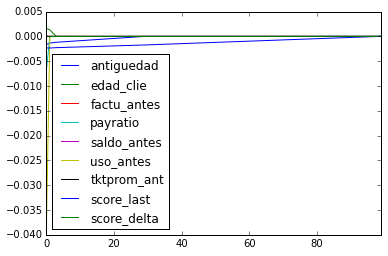

In [151]:
from sklearn import linear_model

L = 100
grid_lamb = np.linspace(0.001,7,L)
BetaLasso = np.zeros((L,nvar))
for l in range(L):
    lambvec = grid_lamb[l]
    clf = linear_model.Lasso(alpha=lambvec)
    clf.fit(prexmat_std,yy_std)
    #print pd.DataFrame(clf.coef_, index = labs_x, columns=['Scikit-Learn'])
    BetaLasso[l,:] = clf.coef_
pd.DataFrame(BetaLasso, columns= labs_x).plot()
plt.legend(loc='best', fontsize=12)

[]

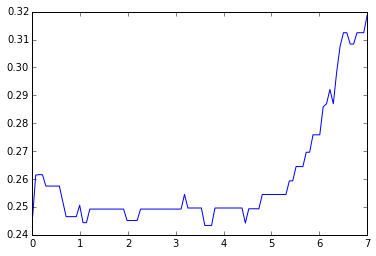

In [212]:
# Vamos a utilizar validación cruzada: 10-CV
grp_cv = 10
ind_grp = np.dot(np.random.multinomial(1,[1.0/grp_cv]*grp_cv, nobs),np.arange(1,grp_cv+1).reshape(grp_cv,1))
CVRes = np.zeros((L,grp_cv))
for g in range(grp_cv):
    # asignemos en entrenamiento y validación
    ind_train = (ind_grp!=g+1).flatten()
    n_train   = ind_train.sum()
    ind_valid = (ind_grp==g+1).flatten()
    n_valid   = ind_valid.sum()
    # y,X
    yy_train = yy_std[ind_train]
    yy_valid = yy_std[ind_valid]
    xx_train = prexmat_std[ind_train,:]
    xx_valid = prexmat_std[ind_valid,:]
    # Para cada grupo tenemos que estimar todo el path de Lasso
    for l in range(L):
        # Lasso con la muestra de entrenamiento
        lambvec = grid_lamb[l]
        clf = linear_model.Lasso(alpha=lambvec)
        clf.fit(xx_train,yy_train)
        # Ahora obtengamos yy_est con la muestra de validación
        pest_valid =  np.dot(xx_valid,(clf.coef_).reshape((nvar,1)))
        # queremos que la clasificación entre clientes malos (yy=1) y cero coincida con el promedio muestral
        # obtengamos el percentil 1-yy_mean
        ptile = np.percentile(pest_valid,100*(1-yy.mean()))
        #ptile = 0
        # listos para clasificar
        clas_est = yy_std.max()*(pest_valid>=ptile)  + yy_std.min()*(pest_valid<ptile)
        # obtengamos el error de clasificación
        misclas_err = np.not_equal(clas_est,yy_valid).mean()
        # guardemos
        CVRes[l,g] = misclas_err
# veamos qué obtuvimos
pd.DataFrame(CVRes, index=grid_lamb).mean(axis=1).plot()
plt.plot()

In [218]:
# Veamos los lambdas asociados: escojamos el primero
lambda_argmin = grid_lamb[pd.DataFrame(CVRes).mean(axis=1).values==pd.DataFrame(CVRes).mean(axis=1).min()][0]
# Obtengamos los coeficientes estimados con este lambd
clf = linear_model.Lasso(alpha=lambda_argmin)
clf.fit(prexmat_std,yy_std)
pd.DataFrame(clf.coef_, index = labs_x, columns=['Lasso_CV'])

,Lasso_CV
antiguedad,-0.000000
edad_clie,-0.000000
factu_antes,-0.000012
payratio,-0.000000
saldo_antes,0.000009
uso_antes,-0.000000
tktprom_ant,0.000000
score_last,-0.001181
score_delta,-0.000000


Encontramos que las variables relevantes son **facturación promedio anterior**, **Saldo Anterior**, **Último Score**.
Clientes que facturaron más, tuvieron un menor saldo promedio en los últimos seis meses y un mayor score crediticio tienen una menor probabilidad de dejar de pagar.

# Punto 3: Función para estimar un logit

In [280]:
def mylogit_fn(Ymat,Xmat):
    # before defining attributes clean data
    xmat    = np.asarray(Xmat)
    K       = xmat.shape[1]
    T       = xmat.shape[0]
    ymat    = np.asarray(Ymat)
    # vamos a limpiar los datos  de missing
    predata = np.asarray(pd.DataFrame(np.concatenate((ymat,xmat), axis=1)).dropna())
    xmat    = predata[:,1:]
    nvar       = xmat.shape[1]
    nobs       = xmat.shape[0]
    ymat    = predata[:,0].reshape((nobs,1))

    #----------------------------------------------
    # NEWTON RAPHSON:
    # Inicialicemos con OLS.  Están mal, pero tienen mismos signos
    olsini  = ols.ols_dan(ymat,xmat)
    beta_old = np.asarray(olsini.betahat()).reshape((olsini.nvar,1))
    #beta_old = np.zeros((nvar,1))
    # Listos para empezar el algoritmo
    dist = 1
    maxIter = 10000
    counter = 0
    while dist>0.0001 and counter<maxIter:
        # Necesitamos la diagonal de W
        xbeta = np.dot(xmat,beta_old)
        Pmat  = np.divide(np.exp(xbeta), 1+np.exp(xbeta))
        PreW  = np.multiply(Pmat,1-Pmat)
        # Eliminemos ceros porque hacen que el problema sea inestable
        PreW[PreW==0] = 0.0000001
        # Y-p
        Y_minusP = ymat - Pmat
        # Usemos broadcasting para obtener el vector que queremos
        w_inv  = 1.0/PreW
        z      = xbeta + np.multiply(w_inv, Y_minusP)
        # producto cruzado ponderado
        # Listos: para invertir la matrix vamos a usar la descomposición de Cholesky 
        # Hace que el problema sea más estable
        premat = np.dot(xmat.T, PreW*xmat)
        newbeta = np.dot(np.linalg.inv(premat),np.dot(xmat.T,np.multiply(PreW,z)))
        dist = np.max(np.abs(beta_old-newbeta))
        # update beta_old
        beta_old = newbeta
        counter +=1
    #return beta_old, counter
    return beta_old

In [278]:
# Simulemos un modelo
np.random.seed(250679)
N = 200

# dos regresores independientes entre sí
x0 = np.ones((N,1))
x1 = 2*np.random.randn(N,1)
x2 = np.random.randn(N,1)
xmat = np.hstack((x0,x1,x2))
beta_true = np.array([-2,3,5]).reshape((3,1))

# vamos a simular residuos de un logit
# Paso 1: simular N números aleatorios de una distribución U[0,1]
# Paso 2: invertir la CDF de una v.a. logística
u = np.random.rand(N,1)
eps = np.log(u) - np.log(1-u)
# variable dependiente latente
y = np.dot(xmat,beta_true) + eps

# necesitamos una variable dicótoma:
d = 1*(y>0)
# vamos la proporción

print d.mean()

0.4


In [285]:
# probemos la función
mylogit_fn(d,xmat)

array([[-2.09552386],
       [ 3.55413408],
       [ 5.92810098]])

# Punto 4: Logit


In [298]:
# estimemos un modelo logit para los datos del punto 1
beta_logit = pd.DataFrame(mylogit_fn(yy,xmat_cons), index=labs_x_cons, columns=['Logit'])
beta_logit

,Logit
constante,9.078780
antiguedad,-0.018686
edad_clie,0.010848
factu_antes,0.000158
payratio,-0.071825
saldo_antes,0.000083
uso_antes,-0.378073
tktprom_ant,-0.000562
score_last,-0.014456
score_delta,0.001197


In [302]:
# miremos los del modelo lineal de probabilidad
linprob = ols.ols_dan(yy,xmat_cons)
beta_linprob = pd.DataFrame(linprob.betahat(), index=labs_x_cons, columns=['OLS'])
pd.concat((beta_linprob, beta_logit),axis=1)

,OLS,Logit
constante,1.839519,9.078780
antiguedad,-0.001630,-0.018686
edad_clie,0.001617,0.010848
factu_antes,0.000017,0.000158
payratio,-0.006738,-0.071825
saldo_antes,0.000011,0.000083
uso_antes,-0.039579,-0.378073
tktprom_ant,-0.000061,-0.000562
score_last,-0.002310,-0.014456
score_delta,0.000067,0.001197


In [325]:
# vamos a obtener los efectos marginales: evaluados en las medias
mean_x = np.nanmean(xmat_cons,axis=0)
xmeanbeta = np.dot(mean_x.reshape((1,nvar+1)),
                  beta_logit.values.reshape((nvar+1,1)))[0,0]
Pmat  = np.divide(np.exp(xmeanbeta), 1+np.exp(xmeanbeta))
margeff = Pmat*(1-Pmat)*beta_logit
margeff.columns = ['EfectosMarg_Logit']
LogitDF = pd.concat((beta_linprob, beta_logit,margeff),axis=1)
LogitDF

,OLS,Logit,EfectosMarg_Logit
constante,1.839519,6.717859,0.946679
antiguedad,-0.001630,-0.025802,-0.003636
edad_clie,0.001617,0.018905,0.002664
factu_antes,0.000017,0.000330,0.000046
payratio,-0.006738,0.012575,0.001772
saldo_antes,0.000011,0.000092,0.000013
uso_antes,-0.039579,-0.567066,-0.079911
tktprom_ant,-0.000061,-0.001990,-0.000280
score_last,-0.002310,-0.010815,-0.001524
score_delta,0.000067,-0.004071,-0.000574


# Una vez tenemos los efectos marginales y los comparamos con los del modelo lineal de probabilidad encontramos que son muy similares

In [330]:
# Finalmente, bootstrapping:
B = 300
BetaBoot   = np.zeros((B,nvar+1))
BetaBootME = np.zeros((B,nvar+1))
for b in range(B):
    ind_b = np.random.choice(nobs,nobs,replace=True)
    beta_logit = pd.DataFrame(mylogit_fn(yy[ind_b],xmat_cons[ind_b,:]), index=labs_x_cons, columns=['Logit'])
    BetaBoot[b,:] = beta_logit.values.flatten()
    # Efectos Marginales
    xmeanbeta = np.dot(mean_x.reshape((1,nvar+1)),
                      beta_logit.values.reshape((nvar+1,1)))[0,0]
    Pmat  = np.divide(np.exp(xmeanbeta), 1+np.exp(xmeanbeta))
    margeff = Pmat*(1-Pmat)*beta_logit
    BetaBootME[b,:] = margeff.values.flatten()

BetaBoot = pd.DataFrame(BetaBoot, columns = labs_x_cons)
BetaBootStd = pd.DataFrame(BetaBoot.std())
BetaBootStd.columns = [u'Error Estándar Coeficientes']
# repitamos para efectos marginales
BetaBootME = pd.DataFrame(BetaBootME, columns = labs_x_cons)
BetaBootMEStd = pd.DataFrame(BetaBootME.std())
BetaBootMEStd.columns = [u'Std Efecto Marginales']
#pd.concat((beta_linprob, beta_logit,margeff),axis=1)
pd.concat((LogitDF, BetaBootStd, BetaBootMEStd),axis=1)

,OLS,Logit,EfectosMarg_Logit,Error Estándar Coeficientes,Std Efecto Marginales
constante,1.839519,6.717859,0.946679,1.833378,0.234230
antiguedad,-0.001630,-0.025802,-0.003636,0.007051,0.000798
edad_clie,0.001617,0.018905,0.002664,0.014482,0.001858
factu_antes,0.000017,0.000330,0.000046,0.000242,0.000029
payratio,-0.006738,0.012575,0.001772,0.088490,0.011569
saldo_antes,0.000011,0.000092,0.000013,0.000048,0.000006
uso_antes,-0.039579,-0.567066,-0.079911,0.233824,0.030000
tktprom_ant,-0.000061,-0.001990,-0.000280,0.001040,0.000137
score_last,-0.002310,-0.010815,-0.001524,0.002745,0.000349
score_delta,0.000067,-0.004071,-0.000574,0.004856,0.000628
